![RFCAN](logo.png "RFCAN_LOGO")

In [ ]:
from codes_RF.prep import PREP

box = [55, 85, -105, -75]
radius =[30, 100]
mag = [5.5, 10.0]
events = [2000, 2030]
year = 3 #years of data

In [ ]:
PREP.preparation(box, radius, mag, events, year, verbose=False)

### Downloading RAW_WFs

To minimize the time spent on downloading from NRCAN, you have the option to specify which networks you want to download from their web server. Simply set nrcan=True to activate downloading from this source.
```
DL.comprehensive_download(NET1, NET2, ..., nrcan=True)
```



In [ ]:
from codes_RF.prep import DL
DL.comprehensive_download("X5","PO", nrcan=True)

### Creating RFs

In [ ]:
from codes_RF.prep import RF
list = RF.mk_rf(filters=[0.05,0.5])

### Manual QC

you can analyze your data set by filtering some part and look at the results

In [ ]:
from codes_RF.prep import QC
QC.preview(filters=["sta_code-eq-TQF","rf_quality-eq-1"], data_type="rf", preview_type="plot")

here you can do QC by examining the RFs and the corresponding RAW_WFs one-on-one

In [ ]:
from codes_RF.prep import QC
QC.manual_quality()

### Automatic QC by DeepQCRF

Doing QC using DeepQCRF is also possible, and you just need to use the following command and also filter your dataset by test_set_keywords:


In [ ]:
from codes_RF.prep import QC

test_set_keywords = ["net_code-eq-X5", "ev_mag-gt-5.0"]
new_df = QC.quality_pred(test_set_keywords)

### Visualizing RFs

Setting your input stations and the bin size for the RFs

In [10]:
from codes_RF.viz import viz

# sta_list = ['DORN', 'MANN', 'MARN', 'NOTN', 'SHMN', 'SHWN', 'CRLN', 'CTSN']
sta_list = ["AKVQ"]
hist_bin = 18

Dataframe has been updated
slow and baz have been added to the dataframe
Plotting the histogram of baz for each station ...
Number of waveforms for AKVQ is 2


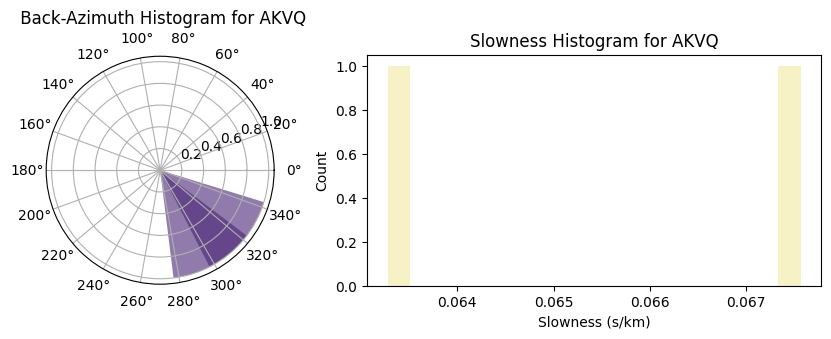

Plotting the slow section for each station ...


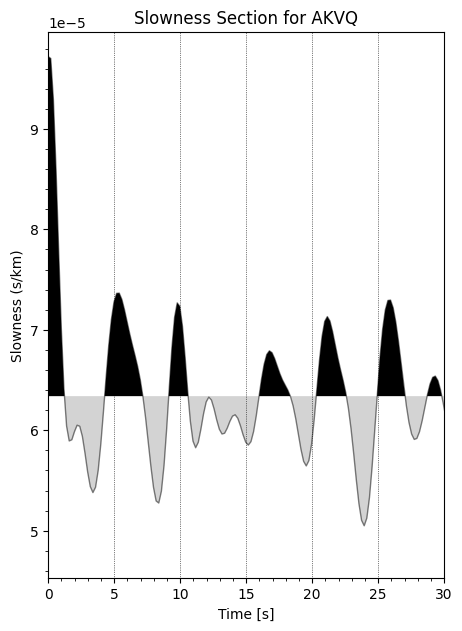

Plotting the baz section for each station ...


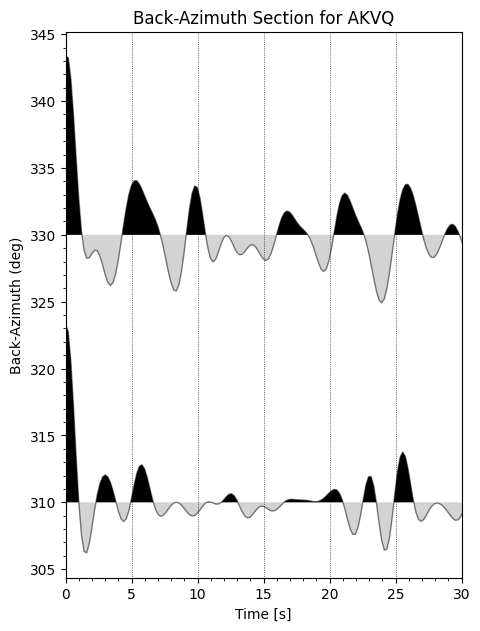

In [11]:
my_proj = viz(sta_list, hist_bin, using_pred=True)   #create a viz object
my_proj.distribution_hist()         #plot distribution histogram for baz and slow
my_proj.plot_section(type="slow")   #plot section for slow
my_proj.plot_section(type="baz")    #plot section for baz

## H-k Stacking

! below station ILON is in both CN and PO networks, so it uses both networks to stack the 

I removed station **AKVQ** from the list cause there is only two waveforms for this station

In [12]:
from codes_RF.hk import HKCan

path_file = "DATA/waveforms_list.csv"
# stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN"]
# # counter =  0      1        2       3       4       5       6       7       8      9       10      11      12      13    14      15      16     17      18     19      20       21

#temp#temp#temp
import numpy as np
import pandas as pd
stations = pd.read_csv(path_file)["sta_code"].unique()
stations = np.array(stations)
stations = np.sort(stations)
stations = np.delete(stations, np.where(stations == "AKVQ"))
stations = np.delete(stations, np.where(stations == "SNKN"))
stations = np.delete(stations, np.where(stations == "KJKQ"))
stations = np.delete(stations, np.where(stations == "MRYN"))
stations = np.delete(stations, np.where(stations == "IVKQ"))
# stations = np.delete(stations, np.where(stations == "JSON"))
print(stations)
stations = ['AKVQ']

for sta in stations:
    print(sta, "++++++++++++++++++++++++++++++++++++++++++++++")
    hkcan = HKCan(path_file, sta, weights=[1,1,-1])#weights=weights[stations.index(sta)])
    hkcan.hk(vp=6.3)
    # hkcan.hk_change_param(weights=[3,1,-1], plot=True, auto_optimization=True)   #weights[stations.index(sta)], plot=True, auto_optimization=True)
    

['AP3N' 'ARVN' 'AXF' 'BLKN' 'BULN' 'CNF' 'CRLN' 'CTSN' 'DORN' 'EUNU' 'FCC'
 'GIFN' 'IBFB' 'IGLN' 'ILON' 'INUQ' 'JOSN' 'KUGN' 'LAIN' 'MANN' 'MARN'
 'MCF' 'MCMN' 'NOTN' 'NUNN' 'POIN' 'QILN' 'RES' 'SAKN' 'SEDN' 'SHMN'
 'SHWN' 'SMLN' 'SRLN' 'STLN' 'TQF' 'WAGN' 'YRTN']
AKVQ ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 2


/Users/sina/Desktop/RFCAN/rfcan/codes_RF/rfpy_pkg/hk.py:210: RuntimeWarning: overflow encountered in scalar power
  weight = abs(weight/len(self.rfV1))**4
/Users/sina/Desktop/RFCAN/rfcan/codes_RF/rfpy_pkg/hk.py:210: RuntimeWarning: invalid value encountered in scalar divide
  weight = abs(weight/len(self.rfV1))**4


Computing: [###############] 61/61


/Users/sina/Desktop/RFCAN/rfcan/codes_RF/rfpy_pkg/hk.py:348: RuntimeWarning: invalid value encountered in add
  stack = (ps + pps + pss)


IndexError: index 0 is out of bounds for axis 0 with size 0

==================== AXF ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 328.0
Number of events = 9


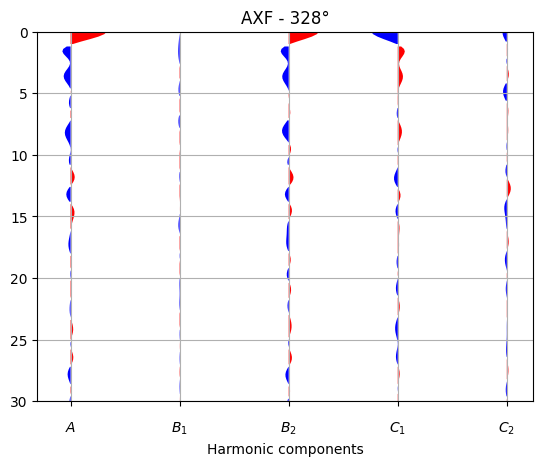

==================== CNF ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 318.0
Number of events = 36


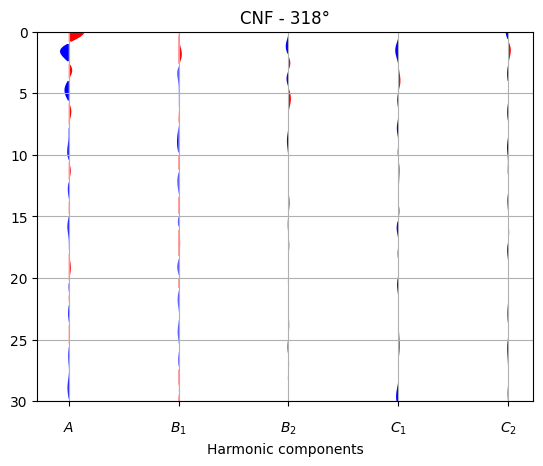

==================== IBFB ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 54.0
Number of events = 17


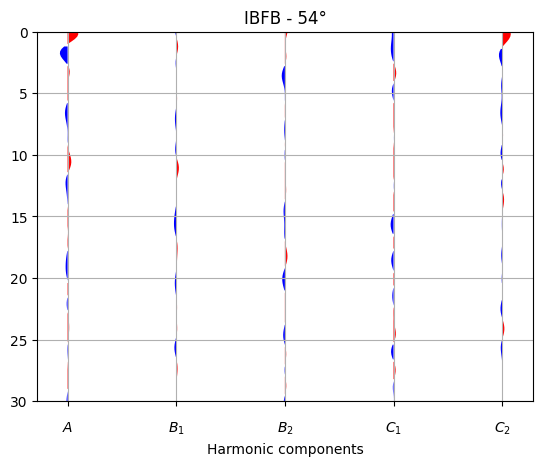

==================== IBFE ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 92.0
Number of events = 42


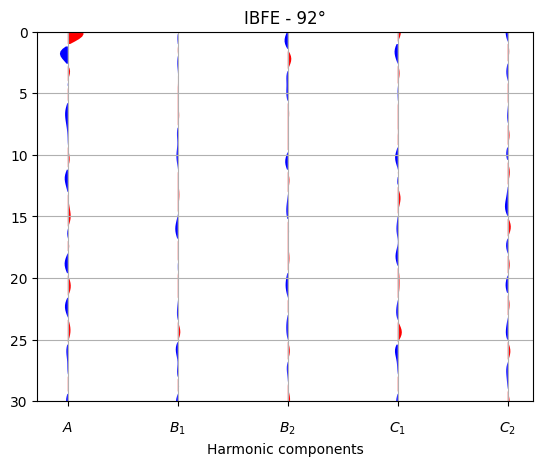

==================== MCF ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 240.0
Number of events = 11


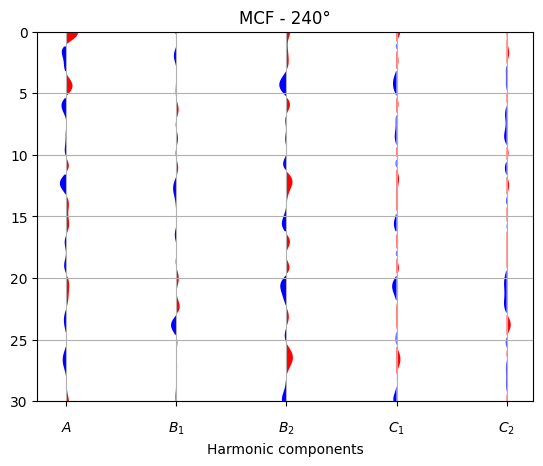

==================== TQF ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 122.0
Number of events = 20


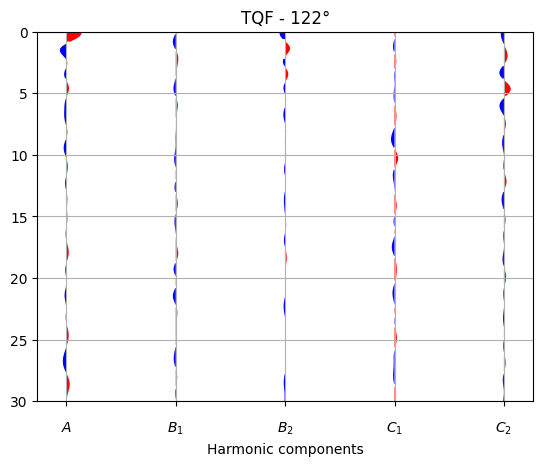

==================== BLKN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 16.0
Number of events = 64


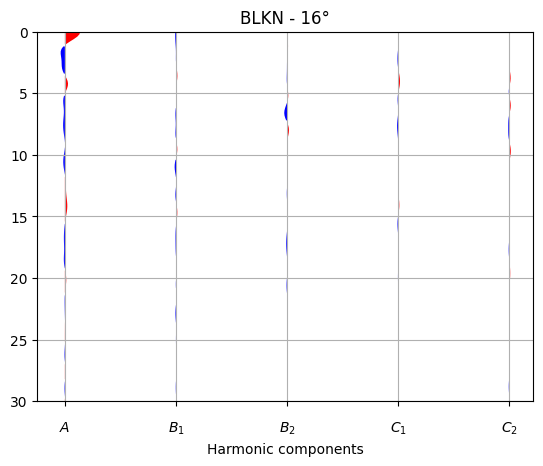

==================== EUNU ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 0.0
Number of events = 23


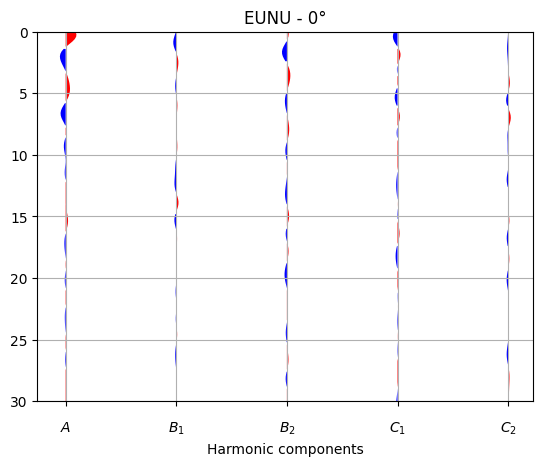

==================== FCC ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 178.0
Number of events = 75


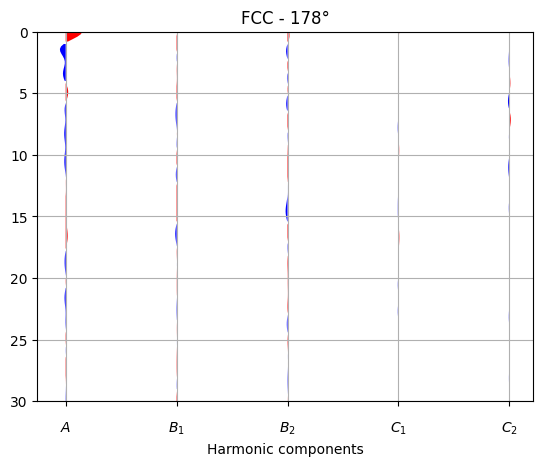

==================== ILON ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 86.0
Number of events = 67


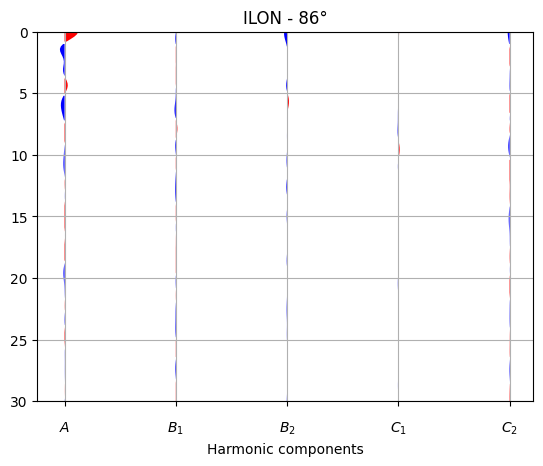

==================== POIN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 90.0
Number of events = 16


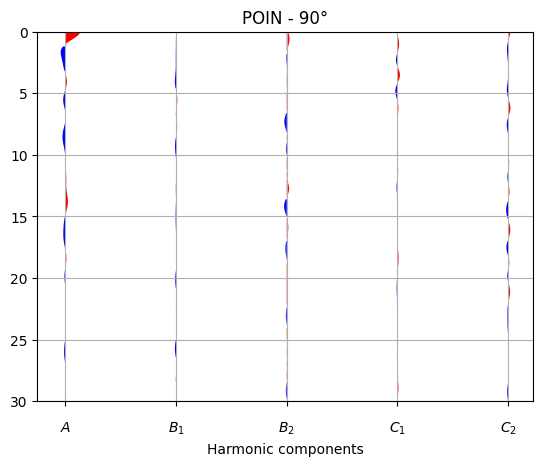

==================== RES ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 62.0
Number of events = 26


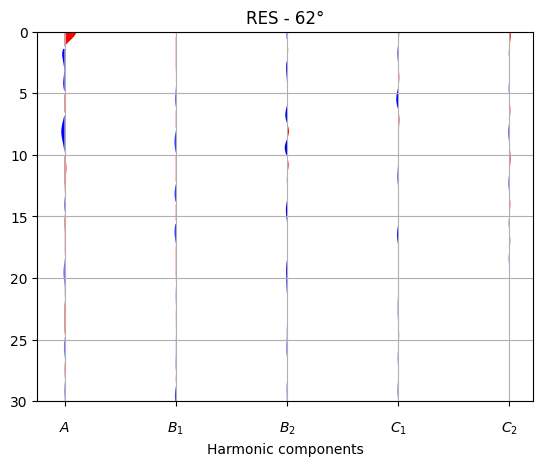

==================== SAKN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 150.0
Number of events = 15


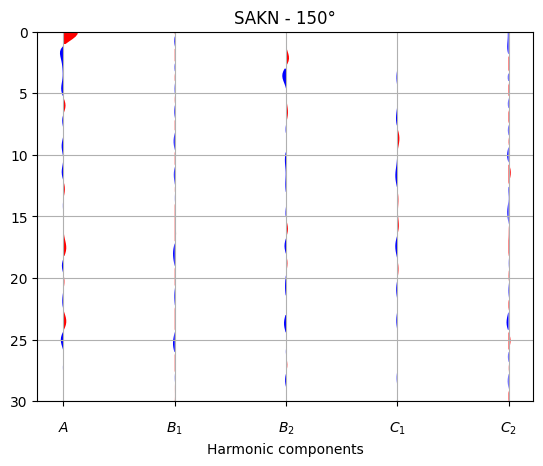

==================== AP3N ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 128.0
Number of events = 19


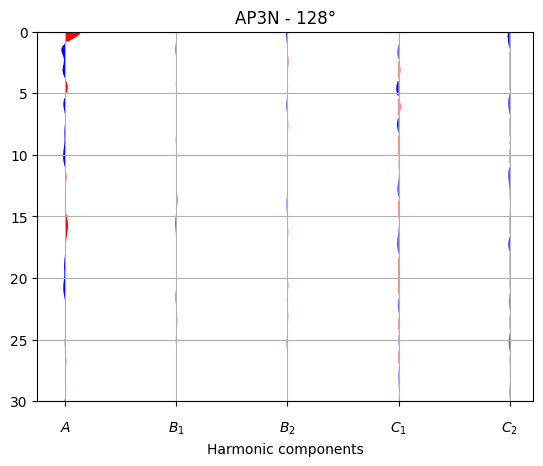

==================== ARVN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 96.0
Number of events = 27


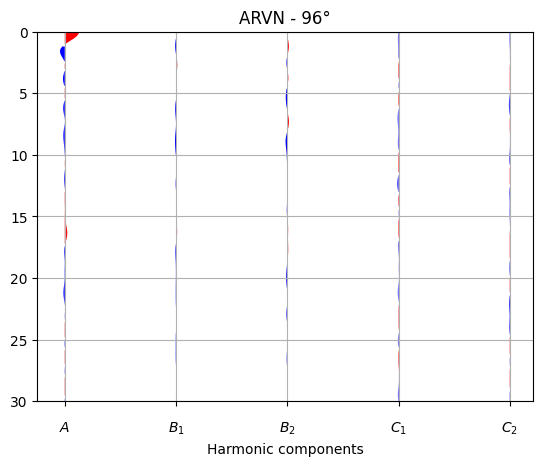

==================== BULN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 322.0
Number of events = 30


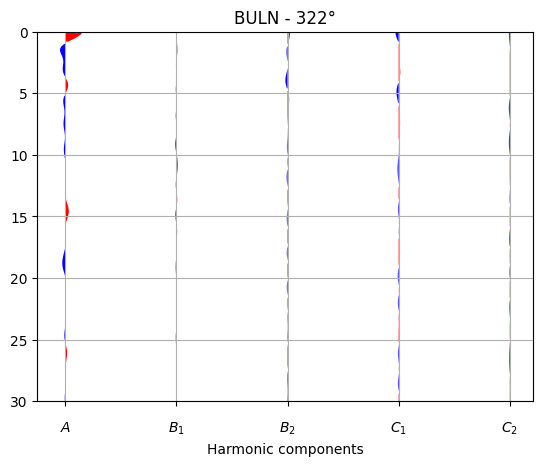

==================== GIFN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 358.0
Number of events = 21


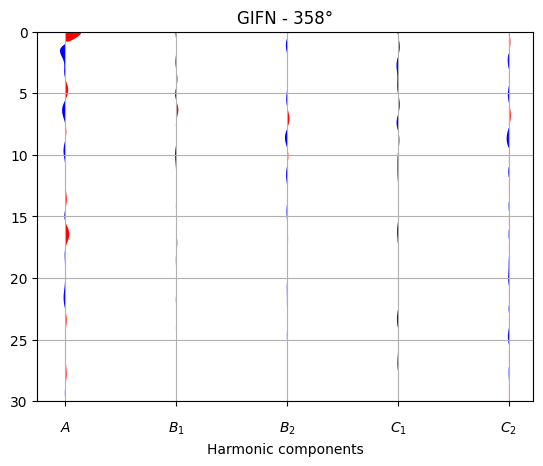

==================== IGLN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 154.0
Number of events = 4


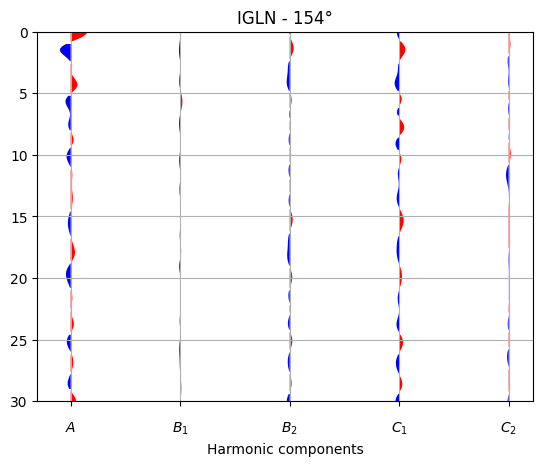

==================== INUQ ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 58.0
Number of events = 18


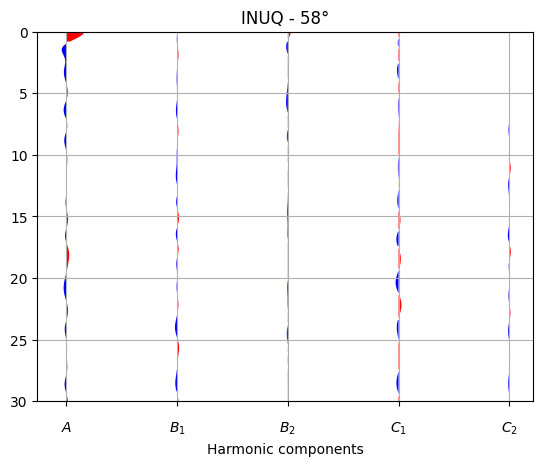

==================== JOSN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 36.0
Number of events = 32


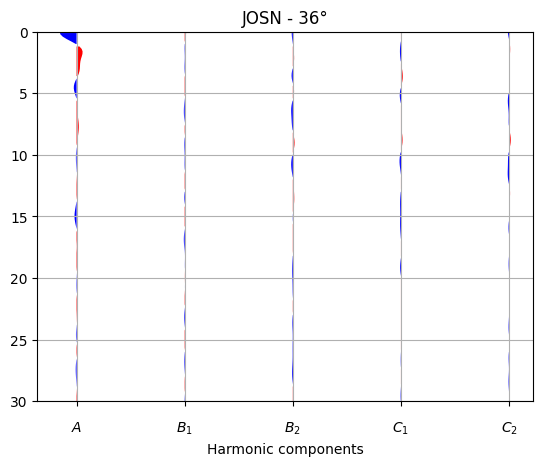

==================== KUGN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 198.0
Number of events = 40


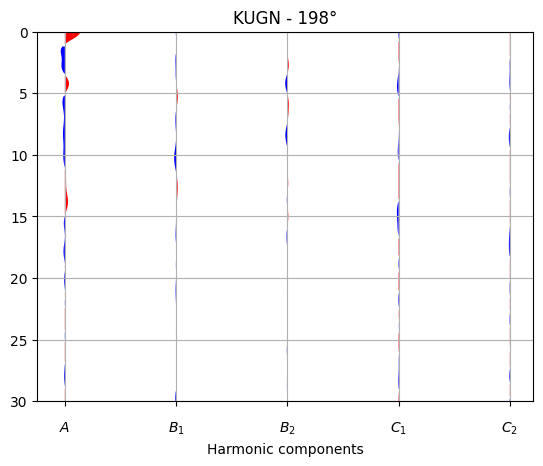

==================== LAIN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 146.0
Number of events = 24


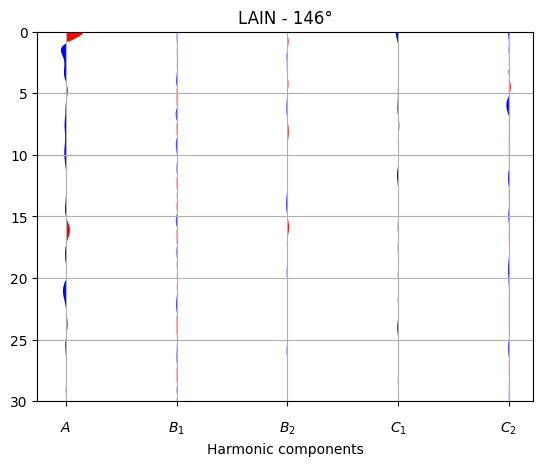

==================== MCMN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 120.0
Number of events = 20


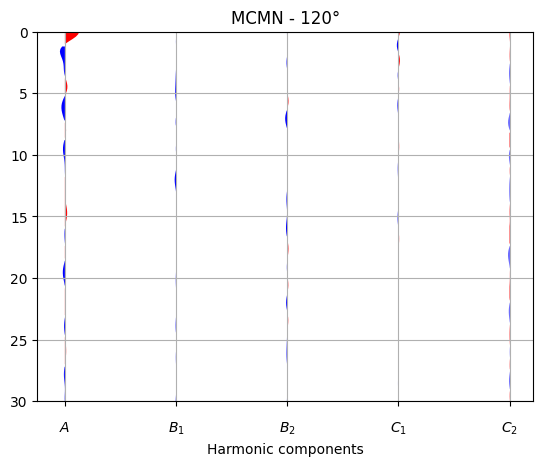

==================== NUNN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 320.0
Number of events = 30


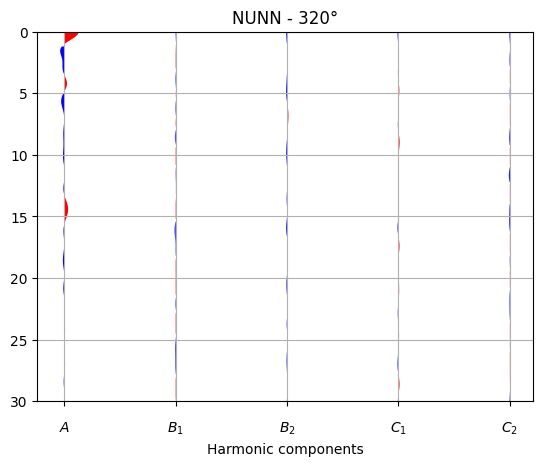

==================== QILN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 122.0
Number of events = 60


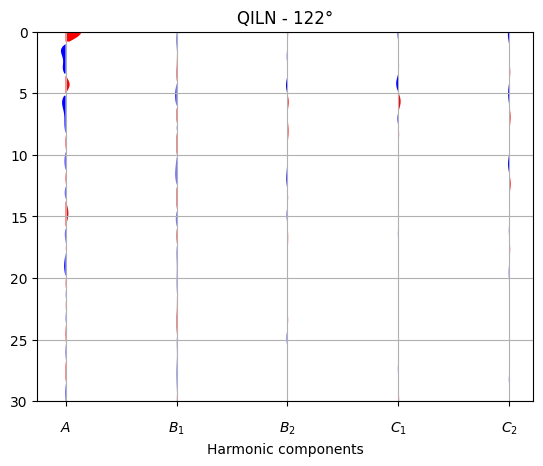

==================== SEDN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 284.0
Number of events = 35


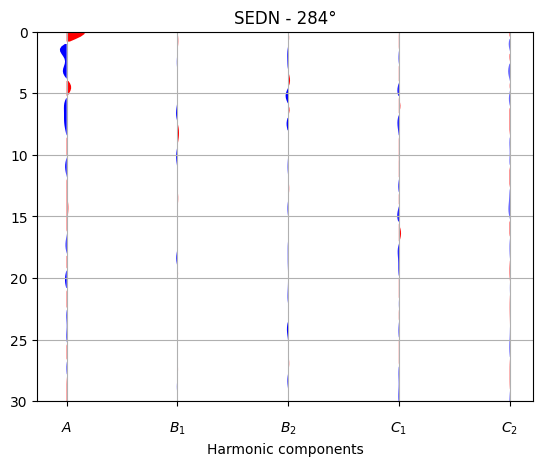

==================== SMLN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 224.0
Number of events = 12


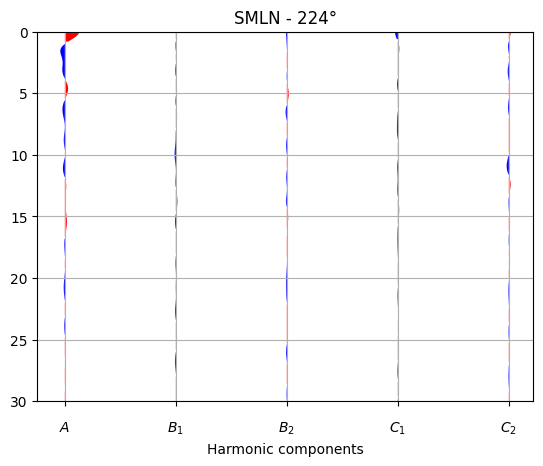

==================== SNQN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 0.0
Number of events = 20


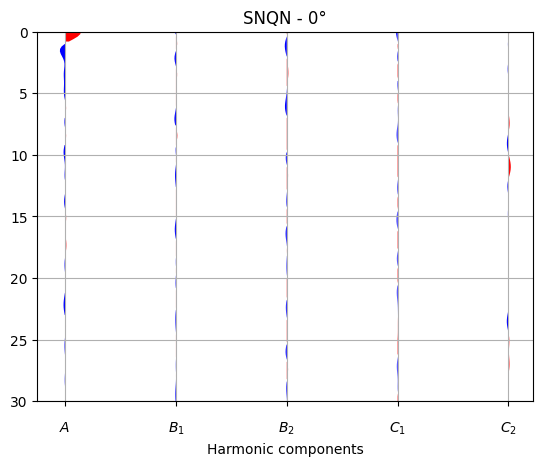

==================== SRLN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 28.0
Number of events = 57


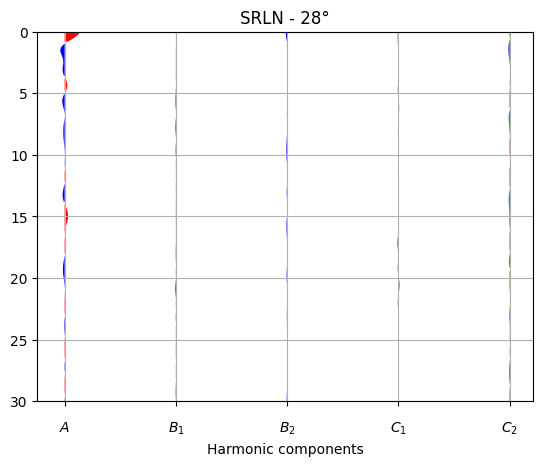

==================== STLN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 32.0
Number of events = 23


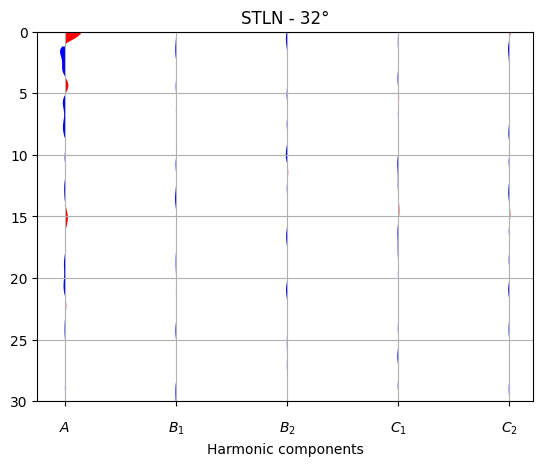

==================== WAGN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 130.0
Number of events = 15


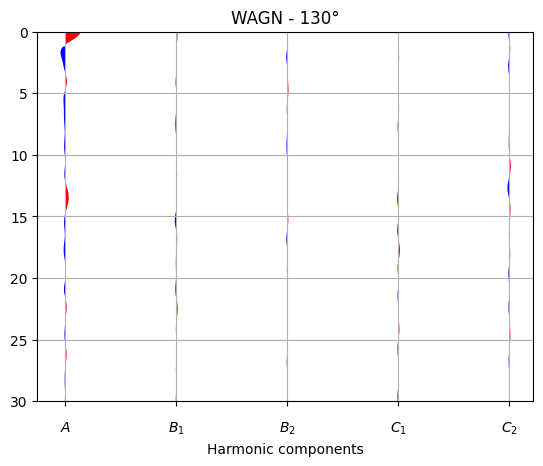

==================== YBKN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 12.0
Number of events = 31


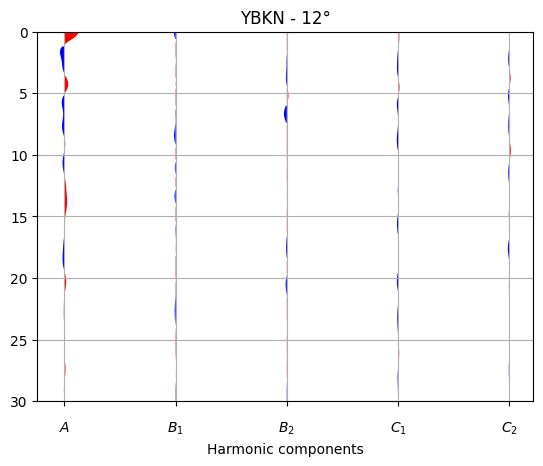

==================== YRTN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 30.0
Number of events = 14


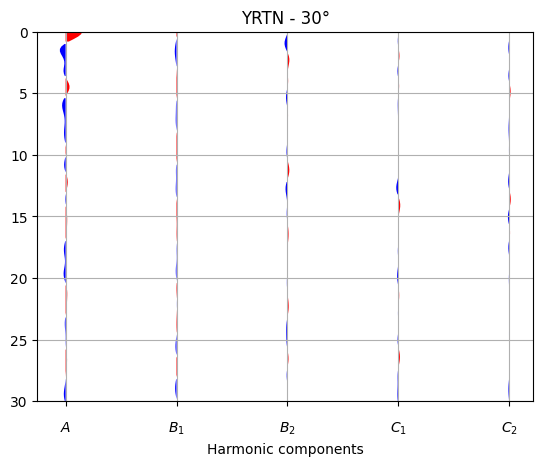

==================== CRLN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 120.0
Number of events = 43


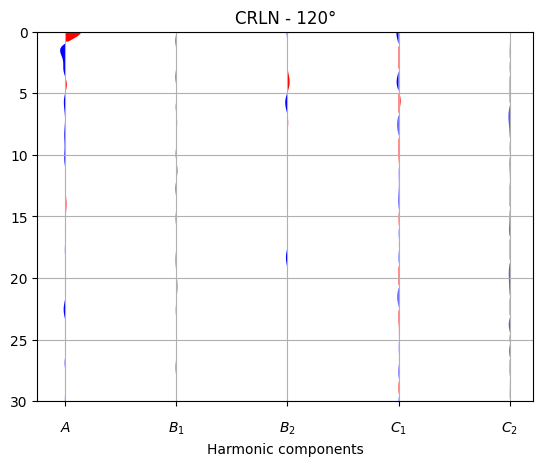

==================== CTSN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 30.0
Number of events = 50


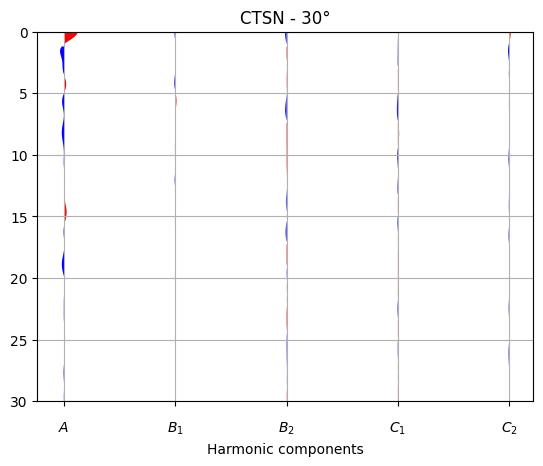

==================== DORN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 108.0
Number of events = 83


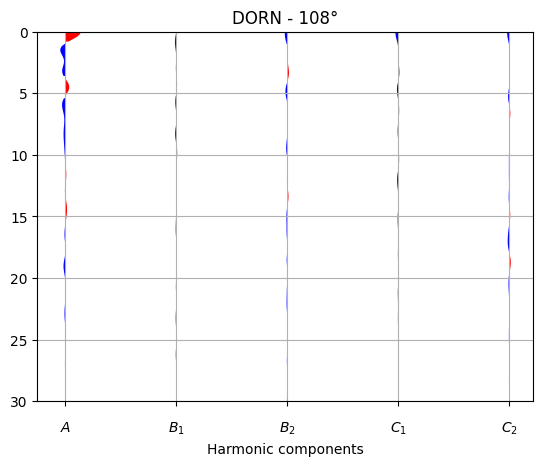

==================== MANN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 142.0
Number of events = 43


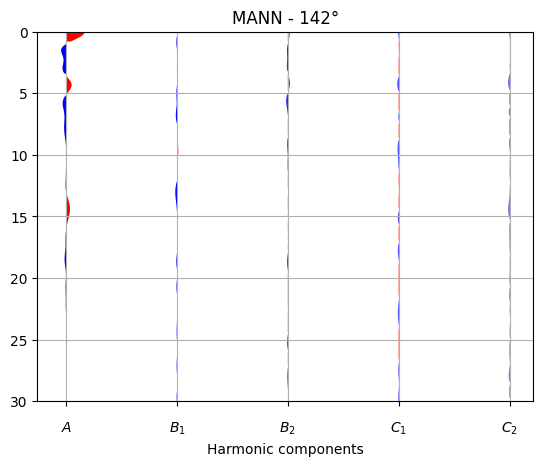

==================== MARN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 278.0
Number of events = 49


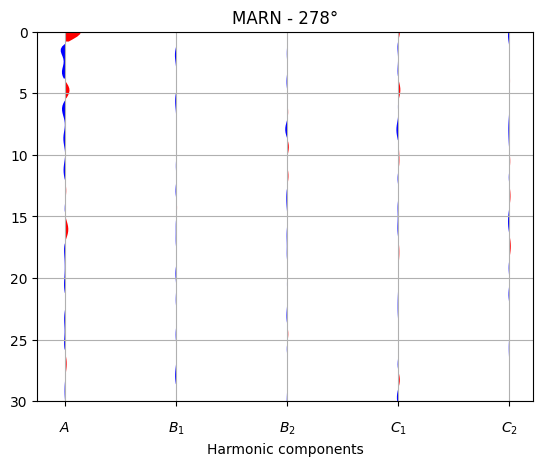

==================== NOTN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 90.0
Number of events = 47


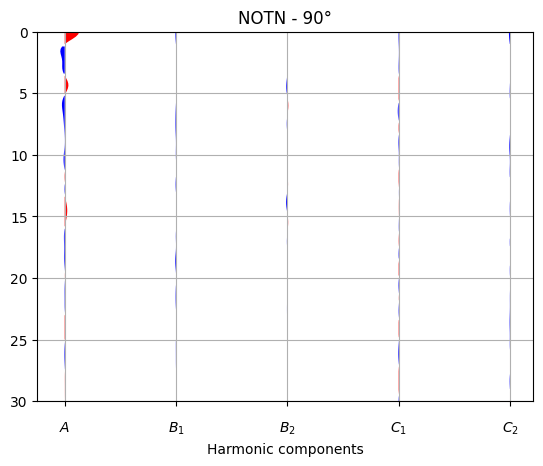

==================== SHMN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 56.0
Number of events = 42


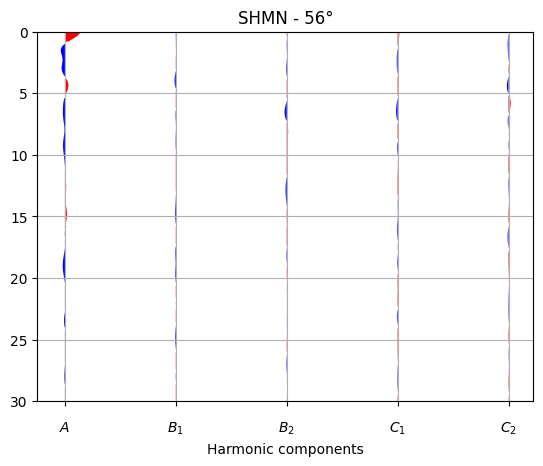

==================== SHWN ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 296.0
Number of events = 40


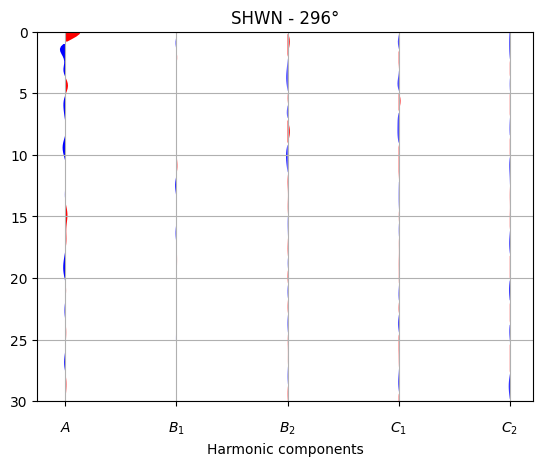

In [3]:
from codes_RF.rfpy_pkg.harmonics import Harmonics
import pandas as pd
import obspy


# stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN"]
# stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN", "AXF", "CNF", "IBFB", "IBFE", "TQF", "MISB1", "MISB2", "PVB1", "PVB2", "BLKN", "EUNU", "FCC", "ILON", "POIN", "RES", "SAKN", "AKVQ", "AP3N", "ARVN", "BULN", "GIFN", "IGLN", "INUQ", "IVKQ", "JSON", "KUGN", "LAIN", "MCMN", "MRYN", "NUNN", "QILN", "SEDN", "SMLN", "SNKN", "SNQN", "SRLN", "STLN", "WAGN", "YBKN", "YRTN"]
stations = pd.read_csv("DATA/waveforms_list.csv")["sta_code"].unique()

#temp#temp#temp
import numpy as np
stations = np.delete(stations, np.where(stations == "AKVQ"))
stations = np.delete(stations, np.where(stations == "SNKN"))
stations = np.delete(stations, np.where(stations == "KJKQ"))
stations = np.delete(stations, np.where(stations == "MRYN"))

for sta in stations:

    print(f"==================== {sta} ====================")
    list_df = pd.read_csv("DATA/waveforms_list.csv")
    list_sta = list_df[(list_df.sta_code == sta) & (list_df.rf_quality == 1)]

    #reading all waveforms R and T
    rfR = obspy.Stream()
    rfT = obspy.Stream()

    for i in range(len(list_sta)):
        file_name = list_sta.file_name.iloc[i]
        path = f"DATA/RF/{file_name}.pkl"
        wf = obspy.read(path)
        rfR += wf.select(channel = "RFR")
        rfT += wf.select(channel = "RFT")

    rfR.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 2, zerophase = True)
    rfT.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 2, zerophase = True)

    harmonics = Harmonics(rfR, rfT)


    harmonics.dcomp_find_azim()

    print(f"{harmonics.azim = }")
    print(f"Number of events = {len(list_sta)}")

    harmonics.plot(scale = 4, title=f"{sta} - {harmonics.azim:.0f}°")

In [ ]:
harmonics.forward(baz_list=[10, 20, 30, 348])

In [ ]:
import matplotlib.pyplot as plt
for tr in harmonics.radial_forward:
    tr.plot()
    plt.show()